### Математическое моделирование
### Лабораторная №2
### Генерация систем непрерывных и дискретных случайных величин

### Задание b
Написать программу реализующую метод формирования двумерной ДСВ. Выполнить статистическое исследование (построение эмпирической матрицы распределения, гистограммы составляющих вектора, вычислить точечные и интервальные оценки, коэффициент корреляции). Проверить гипотезы о соответствии закона распределения полученной случайной величины требуемому. Проверить гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим.

In [44]:
# Imports
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

from statlib.genarator import Generator

In [45]:
plt.style.use('seaborn');
plt.figure(figsize=(14,12));

<Figure size 1008x864 with 0 Axes>

In [12]:
def generate_sample(gen: Generator, n: int):
    return [gen.next() for _ in range(n)]

def get_segments(n):
    if n <= 100: return int(math.sqrt(n))
    return int(2*math.log(n))

def get_base_generator(gen):
    def generator(n):
        return generate_sample(gen, n)
    return generator

In [13]:
gen = Generator()
base_genarator = get_base_generator(gen)

Сгенерируем двумерную матрицу распределений

In [14]:
def generate_prob_matrix(base_genarator, n, m):
    sample = base_genarator(n*m)
    matrix = np.array(sample).reshape(n, m)
    norm_sum = sum(sum(matrix))
    return matrix / norm_sum
    
def generate_X(n):
    res = random.sample(range(n + 5), n)
    return sorted(res)

In [15]:
generate_X(5)

[0, 1, 2, 3, 5]

In [55]:
class DiscreteSystem:
    def __init__(self, XY_distr, gen_size=1000):
        self.distr = XY_distr
        self.p_X = self.get_p_X(XY_distr)
        self.p_Y = self.get_p_Y(XY_distr)
        self.x_intervals = self.get_intervals(self.p_X)
        self.y_intervals = self.get_intervals(self.p_Y)
        self.n, self.m = self.distr.shape
        self.size = self.n * self.m
        self.gen_size = size
        self.X = generate_X(n)
        self.Y = generate_X(m)
        self.emp_matrix = np.zeros((self.n, self.m))
        self.create_emperical_distribution_matrix()
        self.emp_p_X = self.get_p_X(self.emp_matrix)
        self.emp_p_Y = self.get_p_Y(self.emp_matrix)

    # distribution series for X
    def get_p_X(self, prob_matrix) -> list:
        return np.sum(prob_matrix, axis=1)
    
    # distribution series for Y
    def get_p_Y(self, prob_matrix) -> list:
        return np.sum(prob_matrix, axis=0)
    
    def get_intervals(self, p_X: list):
        F_X = [0]
        for i in range(len(p_X)):
            F_X.append(F_X[i] + p_X[i])
        return F_X
    
    def create_emperical_distribution_matrix(self):
        self.fill_matrix()
        self.emp_matrix /= self.gen_size
        
    def fill_matrix(self):
        k, l = 0, 0
        for i in range(self.gen_size):
            val_x = gen.next()
            for j in range(self.n + 1):
                if val_x <= self.x_intervals[j]:
                    k = j - 1
                    break
                    
            y_k_interval = self.get_intervals(self.distr[k])
            val_y = gen.next() * self.p_X[k]
            for j in range(self.m + 1):
                if val_y <= y_k_interval[j]:
                    # print(k, val_x, val_y, y_k_interval)
                    l = j - 1
                    break
            self.emp_matrix[k, l] += 1

In [56]:
def generate_distribution(size: int, n: int, m: int, debug=False):
    XY_prob_matrix = generate_prob_matrix(base_genarator, n, m)
    X = range(n)
    Y = range(m)
    if debug:
        print("X: {}".format(X))
        print("Y: {}".format(Y))
    if abs(sum(sum(XY_prob_matrix)) - 1.0) > 10e-5: raise("Сумма всех элементов != 1")
    return DiscreteSystem(XY_prob_matrix, gen_size=size)

In [65]:
size = 100000
XY_prob_matrix = np.array([[0.2, 0.2],
                             [0.3, 0.3]])
ds = DiscreteSystem(XY_prob_matrix, gen_size=size)
n = 10
m = 8
# ds = generate_distribution(size, n, m, debug=True)

In [66]:
print("Empirical matrix:")
print(ds.emp_matrix)
print()
print("Theoretical matrix:")
print(ds.distr)
print()
print("Theoretical values:")
print("P(X): ", ds.get_p_X(ds.distr))
print("F(X): ", ds.x_intervals)
print()
print("P(Y): ", ds.get_p_Y(ds.distr))
print("F(Y): ", ds.y_intervals)
print()
print("Empirical values: ")
print("P(X): ", ds.get_p_X(ds.emp_matrix))
print("F(X): ", ds.get_intervals(ds.emp_p_X))
print()
print("P(Y): ", ds.get_p_Y(ds.emp_matrix))
print("F(Y): ", ds.get_intervals(ds.emp_p_Y))
print()

Empirical matrix:
[[0.20031 0.1979 ]
 [0.30109 0.3007 ]]

Theoretical matrix:
[[0.2 0.2]
 [0.3 0.3]]

Theoretical values:
P(X):  [0.4 0.6]
F(X):  [0, 0.4, 1.0]

P(Y):  [0.5 0.5]
F(Y):  [0, 0.5, 1.0]

Empirical values: 
P(X):  [0.39821 0.60179]
F(X):  [0, 0.39820999999999995, 1.0]

P(Y):  [0.5014 0.4986]
F(Y):  [0, 0.5014000000000001, 1.0]



### Гистограммы составляющих векторов X и Y

In [63]:
def plot_hist_for_X(ds: DiscreteSystem, width=0.4): 
    XX = np.array(ds.X) + width / 2
    X = np.array(ds.X) - width / 2
    plt.bar(X, ds.emp_p_X, width, color='darkcyan', edgecolor = 'black', alpha=.7, label="Emperical")
    plt.bar(XX, ds.p_X, width, color='darkgreen', edgecolor = 'black', alpha=.7, label="Theoretical")
    plt.title('Probability distribution X components')
    plt.legend()
    plt.show()
    
def plot_hist_for_Y(ds: DiscreteSystem, width=0.4):
    YY = np.array(ds.Y) + width / 2
    Y = np.array(ds.Y) - width / 2
    plt.bar(Y, ds.emp_p_Y, width, color='orange', edgecolor = 'black', alpha=.7)
    plt.bar(YY, ds.p_Y, width, color='darkgreen', edgecolor = 'black', alpha=.7)
    plt.title('Probability distribution Y components')
    plt.show()

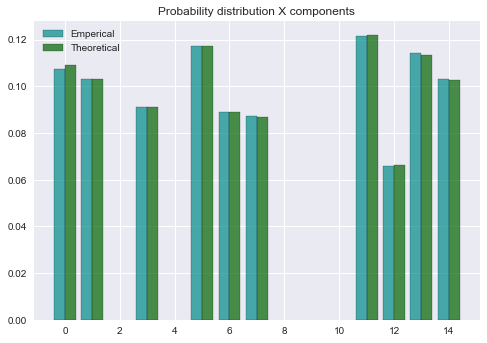

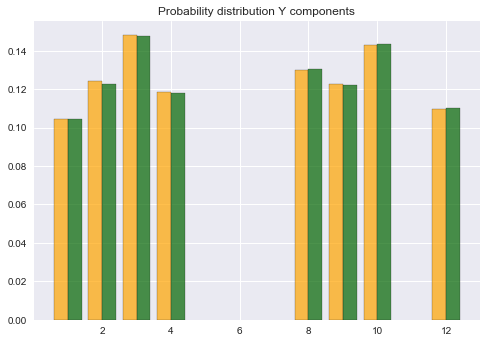

In [64]:
plot_hist_for_X(ds)
plot_hist_for_Y(ds)

### Вычисление точечных оценок
1. Матожидания
2. Дисперсии

In [30]:
def get_math_coeff_X(distr, X):
    return distr.sum(axis=1).dot(X)

def get_math_coeff_Y(distr, Y):
    return distr.sum(axis=0).dot(Y)

def get_math_coeff_XY(distr, X, Y):
    M_X = get_math_coeff_X(distr, X)
    M_Y = get_math_coeff_Y(distr, Y)
    return M_X, M_Y

def get_dispersion_XY(distr, X, Y):
    M_X, M_Y = get_math_coeff_XY(distr, X, Y)
    D_X = distr.sum(axis=1).dot((X - M_X)**2)
    D_Y = distr.sum(axis=0).dot((Y - M_Y)**2)
    return D_X, D_Y

def get_correlation_coeff(distr, X, Y):
    M_X, M_Y = get_math_coeff_XY(distr, X, Y)
    D_X, D_Y = get_dispersion_XY(distr, X, Y)
    X_i, Y_j = (X - M_X), (Y - M_Y)
    n, m = distr.shape
    K_XY = 0
    for i in range(n):
        for j in range(m):
            K_XY += X_i[i] * Y_j[j] * distr[i, j]
    r = K_XY / math.sqrt(D_X * D_Y)
    return r

In [31]:
def get_math_coeff_point_estimation(prob_matrix, X, Y, ns):
    coeff = []
    for n in sizes:
        discrete_sys = DiscreteSystem(prob_matrix, gen_size=n)
        mx, my = get_math_coeff_XY(prob_matrix, X, Y)
        emp_mx, emp_my = get_math_coeff_XY(discrete_sys.emp_matrix, X, Y)
        coeff.append([mx, emp_mx, my, emp_my])
    return pd.DataFrame(data={
        'n': ns,
        'M[X]': [round(x[0],4) for x in coeff],
        'Emperical M[X]': [round(x[1],4) for x in coeff],
        'M[Y]': [round(x[2],4) for x in coeff],
        'Emperical M[Y]': [round(x[3],4) for x in coeff]})


def get_dispersion_point_estimation(prob_matrix, X, Y, ns):
    coeff = []
    for n in sizes:
        discrete_sys = DiscreteSystem(prob_matrix, gen_size=n)
        dx, dy = get_dispersion_XY(prob_matrix, X, Y)
        emp_dx, emp_dy = get_dispersion_XY(discrete_sys.emp_matrix, X, Y)
        coeff.append([dx, emp_dx, dy, emp_dy])
    return pd.DataFrame(data={
        'n': ns,
        'D[X]': [round(x[0],4) for x in coeff],
        'Emperical D[X]': [round(x[1],4) for x in coeff],
        'D[Y]': [round(x[2],4) for x in coeff],
        'Emperical D[Y]': [round(x[3],4) for x in coeff]})


def get_correlation_point_estimation(prob_matrix, X, Y, ns):
    coeff = []
    for n in sizes:
        ds = DiscreteSystem(prob_matrix, gen_size=n)
        k_xy = get_correlation_coeff(ds.emp_matrix, X, Y)
        coeff.append(k_xy)
    return pd.DataFrame(data={
        'n': ns,
        'K_XY': [round(x,4) for x in coeff]})

In [32]:
sizes = [10, 100, 1000, 10000, 100000]
get_math_coeff_point_estimation(ds.distr, ds.X, ds.Y, sizes)

,n,M[X],Emperical M[X],M[Y],Emperical M[Y]
0,10,5.7694,5.7366,7.5396,7.5471
1,100,5.7694,5.7669,7.5396,7.5686
2,1000,5.7694,5.7617,7.5396,7.5367
3,10000,5.7694,5.7520,7.5396,7.5323
4,100000,5.7694,5.7517,7.5396,7.5551


In [33]:
sizes = [10, 100, 1000, 10000, 100000]
get_dispersion_point_estimation(ds.distr, ds.X, ds.Y, sizes)

,n,D[X],Emperical D[X],D[Y],Emperical D[Y]
0,10,21.8004,21.8843,11.9094,11.9060
1,100,21.8004,21.7226,11.9094,11.8543
2,1000,21.8004,21.7696,11.9094,11.9387
3,10000,21.8004,21.8597,11.9094,11.9401
4,100000,21.8004,21.8338,11.9094,11.9237


### Вычисление точечной оценки: коэффициента корреляции

In [34]:
sizes = [10, 100, 1000, 10000, 100000]
get_correlation_point_estimation(ds.distr, ds.X, ds.Y, sizes)

,n,K_XY
0,10,0.0040
1,100,0.0021
2,1000,0.0001
3,10000,-0.0021
4,100000,0.0015


### Построение интервальных оценок
1. Матожидания
2. Дисперсии

### Доверительный интервал для математического ожидания

In [35]:
def get_math_interval(M, D, n, a):
    #Квантиль нормального распределение уровня (1 - a/2)
    stat = sts.norm.ppf(1 - a/2)
    l, r = round(M - math.sqrt(D/(n-1))*stat, 5), round(M + math.sqrt(D/(n-1))*stat, 5)
    return l, r

def math_expectation_interval(ds: DiscreteSystem, X, Y, a):
    M_X, M_Y = get_math_coeff_XY(ds.emp_matrix, X, Y)
    D_X, D_Y = get_dispersion_XY(ds.emp_matrix, X, Y)
    size = ds.n * ds.m
    l_x, r_x = get_math_interval(M_X, D_X, size, a)
    l_y, r_y = get_math_interval(M_Y, D_Y, size, a)
    return ([l_x, r_x], [l_y, r_y])

def show_math_expectation_interval(prob_matrix, X, Y, sizes, alphas):
    coeff = []
    for n in sizes:
        ds = DiscreteSystem(prob_matrix, gen_size=n)
        for a in alphas:
            mei_X, mei_Y = math_expectation_interval(ds, X, Y, a)
            coeff.append([n, a, str(mei_X), abs(mei_X[0] - mei_X[1]), str(mei_Y), abs(mei_Y[0] - mei_Y[1])])
    return pd.DataFrame(data={
            'size': [x[0] for x in coeff],
            'alpha': [x[1] for x in coeff],
            'M(X)': [x[2] for x in coeff],
            '| M1(X) - M2(X) |': [round(x[3],4) for x in coeff],
            'M(Y)': [x[4] for x in coeff],
            '| M1(Y) - M2(Y) |': [round(x[5],4) for x in coeff]})

In [36]:
alphas = [0.5, 0.1, 0.01, 0.001]
sizes = [1000, 10000, 100000]
M_X, M_Y = get_math_coeff_XY(ds.emp_matrix, ds.X, ds.Y)
Mt_X, Mt_Y = get_math_coeff_XY(ds.distr, ds.X, ds.Y)
print('Theoretical D(X): {0}\nEmpirical D(X): {1}\n'.format(round(Mt_X, 5), round(M_X, 5)))
print('Theoretical D(Y): {0}\nEmpirical D(Y): {1}\n'.format(round(Mt_Y, 5), round(M_Y, 5)))
show_math_expectation_interval(ds.distr, ds.X, ds.Y, sizes, alphas)

Theoretical D(X): 5.76942
Empirical D(X): 5.78255

Theoretical D(Y): 7.53957
Empirical D(Y): 7.52387



,size,alpha,M(X),| M1(X) - M2(X) |,M(Y),| M1(Y) - M2(Y) |
0,1000,0.500,"[5.42468, 6.13354]",0.7089,"[7.27077, 7.79507]",0.5243
1,1000,0.100,"[4.91477, 6.64345]",1.7287,"[6.89363, 8.17221]",1.2786
2,1000,0.010,"[4.42556, 7.13266]",2.7071,"[6.5318, 8.53404]",2.0022
3,1000,0.001,"[4.05, 7.50822]",3.4582,"[6.25402, 8.81182]",2.5578
4,10000,0.500,"[5.41254, 6.12032]",0.7078,"[7.27251, 7.79735]",0.5248
5,10000,0.100,"[4.90341, 6.62945]",1.7260,"[6.89497, 8.17489]",1.2799
6,10000,0.010,"[4.41494, 7.11792]",2.7030,"[6.53276, 8.5371]",2.0043
7,10000,0.001,"[4.03996, 7.4929]",3.4529,"[6.25469, 8.81517]",2.5605
8,100000,0.500,"[5.41904, 6.12846]",0.7094,"[7.28519, 7.80877]",0.5236
9,100000,0.100,"[4.90873, 6.63877]",1.7300,"[6.90856, 8.1854]",1.2768


In [37]:
a = 0.05
sts.chi2.ppf(1-a/2, 100000), sts.norm.ppf(1-a/2)

(100878.41530566558, 1.959963984540054)

### Доверительный интервал для дисперсии 
Построим доверительный интервал для дисперсии для разных уровней значимости

In [38]:
def get_dispersion_interval(D, n, a):
    stat = sts.norm.ppf(1-a/2)
    l, r = round(D - math.sqrt(D/(n-1))*stat, 5), round(D + math.sqrt(D/(n-1))*stat, 5)
    return l, r

def dispersion_interval(ds: DiscreteSystem, X, Y, a):
    D_X, D_Y = get_dispersion_XY(ds.emp_matrix, X, Y)
    size = ds.n * ds.m
    l_x, r_x = get_dispersion_interval(D_X, size, a)
    l_y, r_y = get_dispersion_interval(D_Y, size, a)
    return ([l_x, r_x], [l_y, r_y])

def show_dispersion_interval(prob_matrix, X, Y, sizes, alphas):
    coeff = []
    for n in sizes:
        ds = DiscreteSystem(prob_matrix, gen_size=n)
        for a in alphas:
            di_X, di_Y = dispersion_interval(ds, X, Y, a)
            coeff.append([n, a, str(di_X), abs(di_X[0] - di_X[1]), str(di_Y), abs(di_Y[0] - di_Y[1])])
    return pd.DataFrame(data={
            'size': [x[0] for x in coeff],
            'alpha': [x[1] for x in coeff],
            'D(X)': [x[2] for x in coeff],
            '| D1(X) - D2(X) |': [round(x[3],4) for x in coeff], 
            'D(Y)': [x[4] for x in coeff],
            '| D1(Y) - D2(Y) |': [round(x[5],4) for x in coeff]})

In [40]:
alphas = [0.5, 0.1, 0.01, 0.001]
sizes = [1000, 100000]
D_X, D_Y = get_dispersion_XY(ds.emp_matrix, ds.X, ds.Y)
Dt_X, Dt_Y = get_dispersion_XY(ds.distr, ds.X, ds.Y)
print('Theoretical D(X): {0}\nEmpirical D(X): {1}\n'.format(round(Dt_X, 5), round(D_X, 5)))
print('Theoretical D(Y): {0}\nEmpirical D(Y): {1}\n'.format(round(Dt_Y, 5), round(D_Y, 5)))
show_dispersion_interval(ds.distr, ds.X, ds.Y, sizes, alphas)

Theoretical D(X): 21.80037
Empirical D(X): 21.86037

Theoretical D(Y): 11.90942
Empirical D(Y): 11.96339



,size,alpha,D(X),| D1(X) - D2(X) |,D(Y),| D1(Y) - D2(Y) |
0,1000,0.500,"[21.39095, 22.09868]",0.7077,"[11.62507, 12.14833]",0.5233
1,1000,0.100,"[20.88186, 22.60778]",1.7259,"[11.24866, 12.52473]",1.2761
2,1000,0.010,"[20.39342, 23.09621]",2.7028,"[10.88754, 12.88586]",1.9983
3,1000,0.001,"[20.01846, 23.47117]",3.4527,"[10.61031, 13.16309]",2.5528
4,100000,0.500,"[21.45035, 22.15905]",0.7087,"[11.65877, 12.18278]",0.5240
5,100000,0.100,"[20.94055, 22.66885]",1.7283,"[11.28182, 12.55972]",1.2779
6,100000,0.010,"[20.45145, 23.15795]",2.7065,"[10.92018, 12.92136]",2.0012
7,100000,0.001,"[20.07597, 23.53343]",3.4575,"[10.64256, 13.19899]",2.5564


### Критерий согласия Пирсона

In [41]:
def validate_pearson_conditional(p_t, p_e):
    chi = 0
    m = len(p_t)
    for i in range(1, m):
        pi_s = p_t[i]
        pi = p_e[i]
        chi += (pi - pi_s)**2 / pi
    return chi*m

def validate_pearson_table(ds: DiscreteSystem):
    chi = 0
    for i in range(ds.n):
        for j in range(ds.m):
            pij_t = ds.distr[i, j]
            pij = ds.emp_matrix[i, j]
            if pij != 0:
                chi += (pij - pij_t)**2 / pij
    return chi*ds.size

def show_pearson_criterion(n, exp_chi2, alpha):
    table_chi2 = sts.chi2.ppf(alpha, n - 1)
    print('Experimental chi square: {cs}, Table chi square: {tc}'.format(cs=round(exp_chi2, 5), tc=round(table_chi2, 5)))
    if exp_chi2 < table_chi2:
        print('Criterion is accepted')
    else:
        print('Criterion is not accepted')

In [43]:
alpha = 0.01
p_X_t = ds.p_X
p_X_e = ds.emp_p_X
exp_chi2 = validate_pearson_conditional(p_X_t, p_X_e)
print("Chi square for X:")
show_pearson_criterion(len(p_X_t), exp_chi2, alpha)
print()
p_Y_t = ds.p_Y
p_Y_e = ds.emp_p_Y
exp_chi2 = validate_pearson_conditional(p_Y_t, p_Y_e)
print("Chi square for Y:")
show_pearson_criterion(len(p_Y_t), exp_chi2, alpha)
print()
exp_chi2 = validate_pearson_table(ds)
print("Chi square for distribution:")
show_pearson_criterion(ds.size, exp_chi2, alpha)

Chi square for X:
Experimental chi square: 0.0015, Table chi square: 2.0879
Criterion is accepted

Chi square for Y:
Experimental chi square: 0.00011, Table chi square: 1.23904
Criterion is accepted

Chi square for distribution:
Experimental chi square: 0.05629, Table chi square: 52.72468
Criterion is accepted
